<a href="https://colab.research.google.com/github/jblancoperez/fiap-desafio/blob/main/C%C3%B3pia_de_00_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import plot_confusion_matrix




#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension

#!{sys.executable} -m pip install -U lafrom lazypredict.Supervised import LazyClassifier, LazyRegressor

def cm_to_inch(value):
    return value/2.54
#arquivo = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')

In [7]:
#Feature selection class to eliminate multicollinearity

#Baseado em  https://www.youtube.com/watch?v=ioXKxulmwVQ&feature=youtu.be
class MultiCollinearityEliminator():
    
    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
            #central limit theorem
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables 
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is 
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        #Creating the required dataframe, then dropping the target row 
        #and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
        print(corrWithTarget, '\n')
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():                                            
                if(row[column]>self.threshold) and (row[column]<1):
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        print(colCorr, '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():
            print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df

In [8]:
#Remove MultiCollinearity in input
arquivo = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')
df=arquivo.drop(['dataAprovadoNivelAnalista','dataAprovadoEmComite','ativoCirculante','primeiraCompra','numero_solicitacao','razaoSocial', 'nomeFantasia', 'cnpjSemTraco' ],axis=1)

invalidDates = [
    '0019-02-06T03:06:00',
    '0001-01-01T03:06:00',
    '0001-01-01T06:12:00',
    '0019-02-06T03:06:00',
    '0219-12-31T03:06:00'
]

for d in invalidDates:
    df['periodoBalanco']=df['periodoBalanco'].replace(d,np.nan)




df['periodoBalanco']=pd.to_datetime(df['periodoBalanco'],errors='coerce')
df['credito']=df['valorAprovado']>0
df['credito']=df['credito'].astype(int)
df=df.drop(['valorAprovado'],axis=1)

y=df['credito']

ftRemover = MultiCollinearityEliminator(df,'credito',0.1)
df=ftRemover.autoEliminateMulticollinearity()
df=df.drop(['periodoBalanco'],axis=1)
df.info()

['prazoMedioRecebimentoVendas', 'margemBrutaAcumulada', 'titulosEmAberto', 'endividamento', 'estoque', 'scorePontualidade', 'periodoDemonstrativoEmMeses', 'capitalSocial', 'limiteEmpresaAnaliseCredito', 'dashboardCorrelacao', 'diferencaPercentualRisco', 'anoFundacao', 'percentualRisco', 'totalAtivo', 'passivoCirculante', 'totalPatrimonioLiquido', 'duplicatasAReceber', 'faturamentoBruto', 'margemBruta', 'custos'] 

                              credito
capitalSocial                0.004086
duplicatasAReceber           0.008320
titulosEmAberto              0.009147
totalAtivo                   0.012593
passivoCirculante            0.012833
prazoMedioRecebimentoVendas  0.016377
endividamento                0.017386
maiorAtraso                  0.017762
totalPatrimonioLiquido       0.017873
custos                       0.018894
percentualProtestos          0.019233
limiteEmpresaAnaliseCredito  0.019646
dashboardCorrelacao          0.020735
estoque                      0.021635
faturamentoB

In [9]:
#Create dummy columns

df=pd.get_dummies(df, columns=["definicaoRisco","status","empresa_MeEppMei","restricoes","intervaloFundacao",], prefix=["definicaoRisco","status","mei","restricoes","intervaloFundacao",])
df.info()
df[df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   maiorAtraso                               8973 non-null   int64  
 1   percentualProtestos                       7475 non-null   float64
 2   valorSolicitado                           8973 non-null   float64
 3   diferencaPercentualRisco                  8973 non-null   float64
 4   percentualRisco                           8973 non-null   float64
 5   scorePontualidade                         8973 non-null   float64
 6   credito                                   8973 non-null   int64  
 7   definicaoRisco_De 0 a 10 % - Muito Baixo  8973 non-null   uint8  
 8   definicaoRisco_De 11 a 30 % - Baixo       8973 non-null   uint8  
 9   definicaoRisco_De 31 a 50 % - Médio       8973 non-null   uint8  
 10  definicaoRisco_De 51 a 80 % - Alto  

,maiorAtraso,percentualProtestos,valorSolicitado,diferencaPercentualRisco,percentualRisco,scorePontualidade,credito,definicaoRisco_De 0 a 10 % - Muito Baixo,definicaoRisco_De 11 a 30 % - Baixo,definicaoRisco_De 31 a 50 % - Médio,...,status_ReprovadoAnalista,status_ReprovadoComite,mei_False,mei_True,restricoes_False,restricoes_True,intervaloFundacao_Acima de 17 anos,intervaloFundacao_De 0 a 5 anos,intervaloFundacao_De 11 a 16 anos,intervaloFundacao_De 6 a 10 anos
1,0,NaN,10000.0,1.000000,0.000000,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,NaN,25000.0,0.396226,0.603774,0.0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
5,0,NaN,25000.0,0.622642,0.377358,0.0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,1
6,16,NaN,100000.0,0.584906,0.415094,0.0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
10,7,NaN,1000000.0,0.603774,0.396226,0.0,1,0,0,1,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,6,NaN,400000.0,0.803571,0.196429,0.0,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0
8829,0,NaN,30000.0,0.517857,0.482143,0.0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
8861,69,NaN,100000.0,0.821429,0.178571,0.0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
8948,7,NaN,650000.0,0.803571,0.196429,0.0,1,0,1,0,...,0,0,0,1,1,0,1,0,0,0


Nearest Neighbors 0.9994428969359331


<Figure size 708.661x425.197 with 0 Axes>

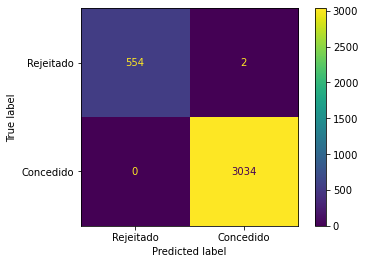

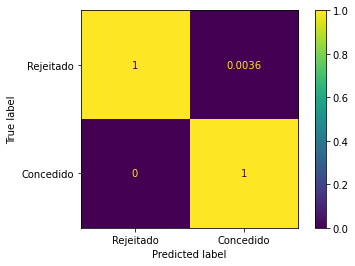

Linear SVM 0.9997214484679666


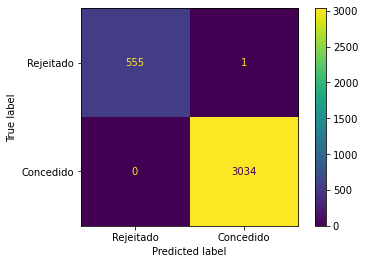

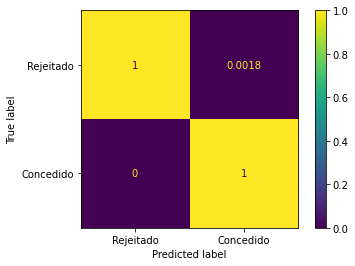

RBF SVM 0.9997214484679666


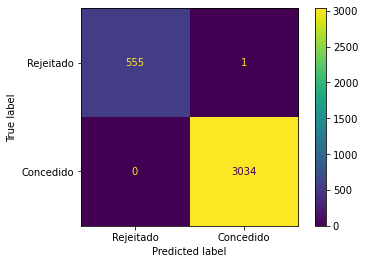

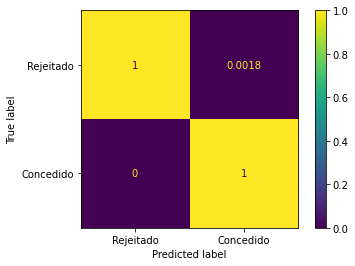

Naive Bayes 0.22172701949860724


/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


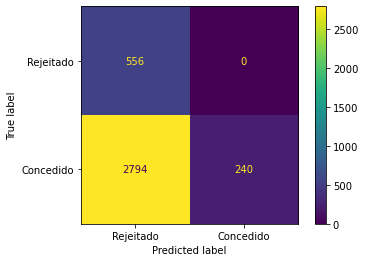

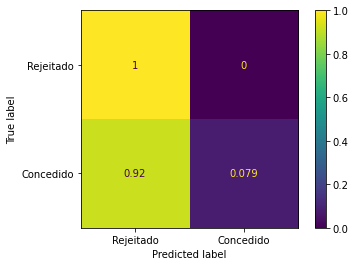

In [10]:
df=df.fillna(method='bfill',axis=1)

X= df.drop(['credito'], axis=1)
X = StandardScaler().fit_transform(X)


names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         #"Gaussian Process",
         #"Decision Tree", 
         #"Random Forest", 
         #"Neural Net", 
         #"AdaBoost",
         "Naive Bayes", 
         "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
l=len(classifiers)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

class_names=['Rejeitado', 'Concedido']
plt.figure(figsize=(cm_to_inch(25), cm_to_inch(15)))

import sklearn.metrics

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print (name,score)
  
    i=1
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        i+=1
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 normalize=normalize)

#        accuracy_score = metrics.accuracy_score(y_test, y_pred)
#        precision_score = metrics.precision_score(y_test, y_pred)
#        metrics.recall_score = metrics.recall_score(y_test, y_pred)
#        metrics.f1_score = metrics.f1_score(y_test, y_pred)
        plt.show()    
    
